### Custom ELECTRA Architecture:

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Train Loss: 1.677, Train Acc: 0.414
Epoch: 2, Train Loss: 0.685, Train Acc: 0.809
Epoch: 3, Train Loss: 0.306, Train Acc: 0.919
Epoch: 4, Train Loss: 0.183, Train Acc: 0.955
Epoch: 5, Train Loss: 0.108, Train Acc: 0.975
Epoch: 6, Train Loss: 0.080, Train Acc: 0.983
Epoch: 7, Train Loss: 0.037, Train Acc: 0.992
Epoch: 8, Train Loss: 0.044, Train Acc: 0.990
Epoch: 9, Train Loss: 0.059, Train Acc: 0.983
Epoch: 10, Train Loss: 0.045, Train Acc: 0.988
Epoch: 11, Train Loss: 0.018, Train Acc: 0.996
Epoch: 12, Train Loss: 0.025, Train Acc: 0.994
Epoch: 13, Train Loss: 0.040, Train Acc: 0.989
Epoch: 14, Train Loss: 0.035, Train Acc: 0.991
Epoch: 15, Train Loss: 0.015, Train Acc: 0.996
Epoch: 16, Train Loss: 0.011, Train Acc: 0.997
Epoch: 17, Train Loss: 0.026, Train Acc: 0.993
Epoch: 18, Train Loss: 0.053, Train Acc: 0.984
Epoch: 19, Train Loss: 0.031, Train Acc: 0.991
Epoch: 20, Train Loss: 0.048, Train Acc: 0.984
Epoch: 21, Train Loss: 0.024, Train Acc: 0.995
Epoch: 22, Train Loss:

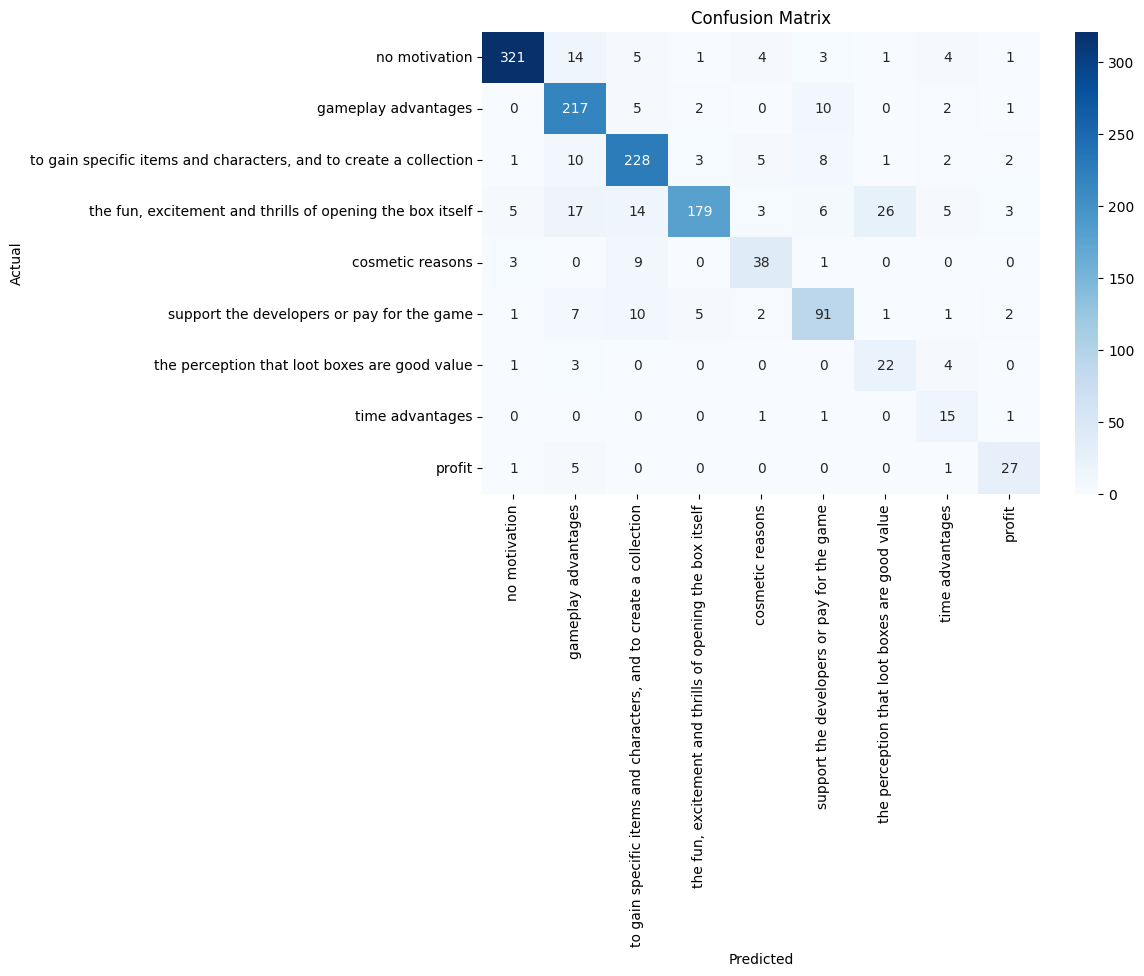

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraModel, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the datasets
file_path_el = '/content/combined_training_dataset.csv'
df_el = pd.read_csv(file_path_el)

test_file_path_el = '/content/first_dataset_testing.csv'
df_test_el = pd.read_csv(test_file_path_el)
df_test_el = df_test_el.dropna(subset=['Text'])

# Define the motivation dictionary
motivation_el = {
    0: 'no motivation',
    2: 'gameplay advantages',
    5: 'to gain specific items and characters, and to create a collection',
    1: 'the fun, excitement and thrills of opening the box itself',
    3: 'cosmetic reasons',
    8: 'support the developers or pay for the game',
    7: 'the perception that loot boxes are good value',
    4: 'time advantages',
    6: 'profit'
}

# Initialize the tokenizer
tokenizer_el = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

MAX_SEQ_LEN_EL = 512
BATCH_SIZE_EL = 12
PAD_INDEX_EL = tokenizer_el.convert_tokens_to_ids(tokenizer_el.pad_token)
UNK_INDEX_EL = tokenizer_el.convert_tokens_to_ids(tokenizer_el.unk_token)

# Tokenize function
def tokenize_and_cut_el(sentence):
    tokens = tokenizer_el.encode(sentence, max_length=MAX_SEQ_LEN_EL, truncation=True)
    return tokens

# Create custom dataset class
class TextDatasetEl(Dataset):
    def __init__(self, df):
        self.texts = df['Text'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = tokenize_and_cut_el(text)
        tokens = torch.tensor(tokens)
        return tokens, int(label)

# Create the datasets
train_dataset_el = TextDatasetEl(df_el)
test_dataset_el = TextDatasetEl(df_test_el)

# Collate function for DataLoader
def collate_fn_el(batch):
    input_ids = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    input_ids_padded = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=PAD_INDEX_EL)
    labels = torch.tensor(labels)
    return input_ids_padded.to(device), labels.to(device)

# Create DataLoaders
train_loader_el = DataLoader(train_dataset_el, batch_size=BATCH_SIZE_EL, shuffle=True, collate_fn=collate_fn_el)
test_loader_el = DataLoader(test_dataset_el, batch_size=BATCH_SIZE_EL, shuffle=False, collate_fn=collate_fn_el)

# Define the model
class ELECTRAClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ELECTRAClassifier, self).__init__()
        self.electra = ElectraModel.from_pretrained('google/electra-base-discriminator')
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(768, len(motivation_el))
        )

    def forward(self, input_ids, attention_mask=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.classifier(x)
        return x

model_el = ELECTRAClassifier().to(device)

optimizer_el = AdamW(model_el.parameters(), lr=2e-5)
criterion_el = nn.CrossEntropyLoss().to(device)

# Training loop
def train_model_el(model_el, loader_el, optimizer_el, criterion_el):
    model_el.train()
    epoch_loss_el = 0
    epoch_acc_el = 0
    for input_ids, labels in loader_el:
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        attention_mask = (input_ids != PAD_INDEX_EL).float()

        optimizer_el.zero_grad()
        predictions = model_el(input_ids, attention_mask)
        loss = criterion_el(predictions, labels)
        acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer_el.step()

        epoch_loss_el += loss.item()
        epoch_acc_el += acc
    return epoch_loss_el / len(loader_el), epoch_acc_el / len(loader_el)

# Evaluation loop
def evaluate_model_el(model_el, loader_el, criterion_el):
    model_el.eval()
    epoch_loss_el = 0
    epoch_acc_el = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for input_ids, labels in loader_el:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = (input_ids != PAD_INDEX_EL).float()

            predictions = model_el(input_ids, attention_mask)
            loss = criterion_el(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

            epoch_loss_el += loss.item()
            epoch_acc_el += acc

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return epoch_loss_el / len(loader_el), epoch_acc_el / len(loader_el), f1, precision, recall, conf_matrix

# Train the model
NUM_EPOCHS_EL = 30
for epoch in range(NUM_EPOCHS_EL):
    train_loss_el, train_acc_el = train_model_el(model_el, train_loader_el, optimizer_el, criterion_el)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_el:.3f}, Train Acc: {train_acc_el:.3f}')

# Evaluate on the test set
test_loss_el, test_acc_el, test_f1_el, test_precision_el, test_recall_el, test_conf_matrix_el = evaluate_model_el(model_el, test_loader_el, criterion_el)
print(f'Test Loss: {test_loss_el:.3f}, Test Acc: {test_acc_el:.3f}, Test F1: {test_f1_el:.3f}')
print(f'Test Precision: {test_precision_el:.3f}, Test Recall: {test_recall_el:.3f}')

print('Confusion Matrix:')
print(test_conf_matrix_el)

plt.figure(figsize=(9,6))
sns.heatmap(test_conf_matrix_el, annot=True, fmt="d", cmap="Blues", xticklabels=motivation_el.values(), yticklabels=motivation_el.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Custom RoBERTa:



Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Train Loss: 1.773, Train Acc: 0.399
Epoch: 2, Train Loss: 0.980, Train Acc: 0.780
Epoch: 3, Train Loss: 0.737, Train Acc: 0.870
Epoch: 4, Train Loss: 0.585, Train Acc: 0.917
Epoch: 5, Train Loss: 0.492, Train Acc: 0.937
Epoch: 6, Train Loss: 0.420, Train Acc: 0.961
Epoch: 7, Train Loss: 0.370, Train Acc: 0.964
Epoch: 8, Train Loss: 0.335, Train Acc: 0.969
Epoch: 9, Train Loss: 0.289, Train Acc: 0.979
Epoch: 10, Train Loss: 0.268, Train Acc: 0.978
Epoch: 11, Train Loss: 0.235, Train Acc: 0.985
Epoch: 12, Train Loss: 0.220, Train Acc: 0.982
Epoch: 13, Train Loss: 0.205, Train Acc: 0.984
Epoch: 14, Train Loss: 0.168, Train Acc: 0.991
Epoch: 15, Train Loss: 0.170, Train Acc: 0.985
Epoch: 16, Train Loss: 0.163, Train Acc: 0.987
Epoch: 17, Train Loss: 0.135, Train Acc: 0.993
Epoch: 18, Train Loss: 0.123, Train Acc: 0.992
Epoch: 19, Train Loss: 0.117, Train Acc: 0.992
Epoch: 20, Train Loss: 0.109, Train Acc: 0.992
Epoch: 21, Train Loss: 0.117, Train Acc: 0.989
Epoch: 22, Train Loss:

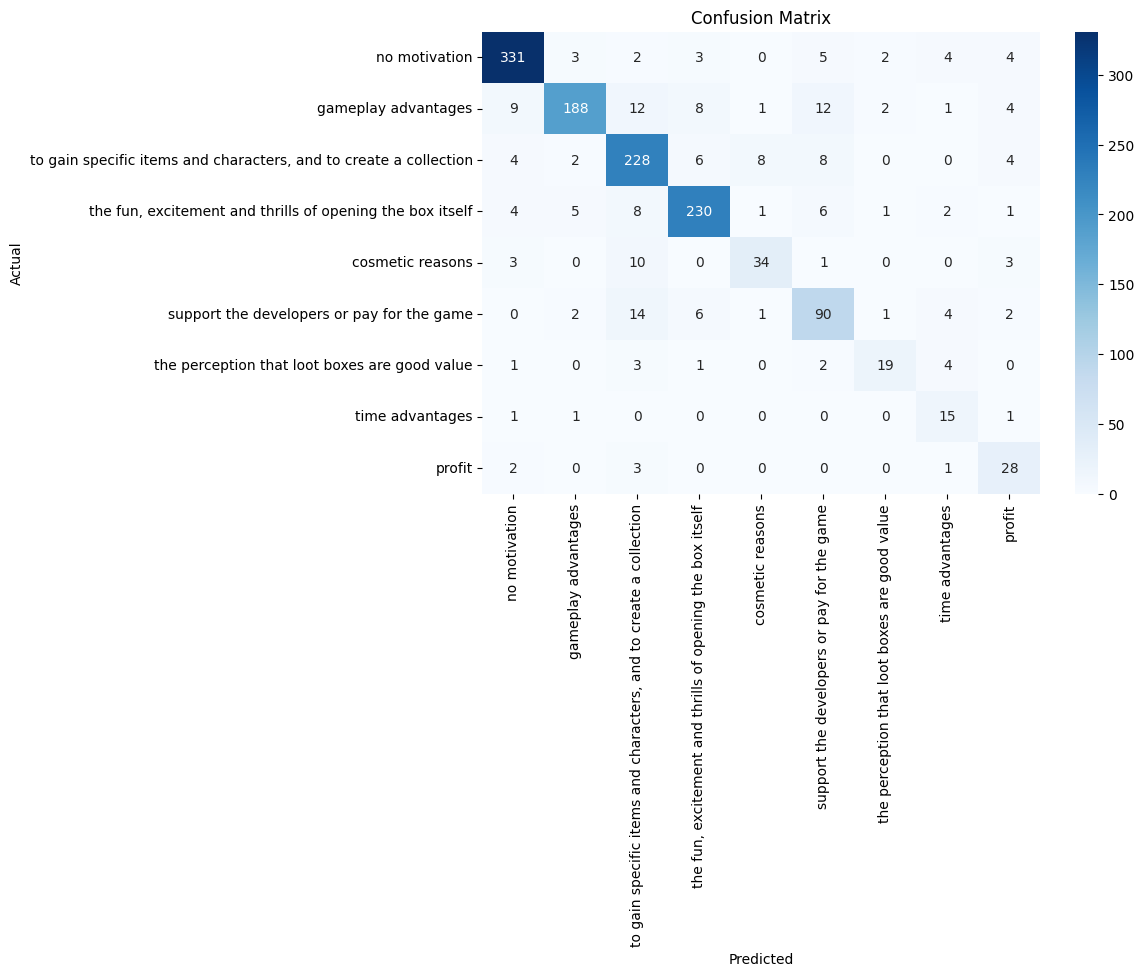

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the training dataset
file_path_rob = '/content/combined_training_dataset.csv'
df_rob = pd.read_csv(file_path_rob)
df_rob = df_rob.dropna(subset=['Text'])

motivation_rob = {
    0: 'no motivation',
    2: 'gameplay advantages',
    5: 'to gain specific items and characters, and to create a collection',
    1: 'the fun, excitement and thrills of opening the box itself',
    3: 'cosmetic reasons',
    8: 'support the developers or pay for the game',
    7: 'the perception that loot boxes are good value',
    4: 'time advantages',
    6: 'profit'
}

tokenizer_rob = RobertaTokenizer.from_pretrained('roberta-base')

MAX_SEQ_LEN_ROB = 512
BATCH_SIZE_ROB = 12
PAD_INDEX_ROB = tokenizer_rob.convert_tokens_to_ids(tokenizer_rob.pad_token)
UNK_INDEX_ROB = tokenizer_rob.convert_tokens_to_ids(tokenizer_rob.unk_token)

def tokenize_and_cut_rob(sentence):
    tokens = tokenizer_rob.encode(sentence, max_length=MAX_SEQ_LEN_ROB, truncation=True)
    return tokens

class TextDatasetRob(Dataset):
    def __init__(self, df):
        self.texts = df['Text'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = tokenize_and_cut_rob(text)
        tokens = torch.tensor(tokens)
        return tokens, int(label)

train_dataset_rob = TextDatasetRob(df_rob)

def collate_fn_rob(batch):
    input_ids = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    input_ids_padded = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=PAD_INDEX_ROB)
    labels = torch.tensor(labels)
    return input_ids_padded.to(device), labels.to(device)

train_loader_rob = DataLoader(train_dataset_rob, batch_size=BATCH_SIZE_ROB, shuffle=True, collate_fn=collate_fn_rob)

class ROBERTAClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ROBERTAClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        for param in self.roberta.parameters():
            param.requires_grad = False
        for param in self.roberta.encoder.layer[-5:].parameters():
            param.requires_grad = True

        self.d1_rob = nn.Dropout(dropout_rate)
        self.l1_rob = nn.Linear(768, 64)
        self.bn1_rob = nn.LayerNorm(64)
        self.d2_rob = nn.Dropout(dropout_rate)
        self.l2_rob = nn.Linear(64, len(motivation_rob))

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs[1]
        x = self.d1_rob(x)
        x = self.l1_rob(x)
        x = self.bn1_rob(x)
        x = torch.nn.Tanh()(x)
        x = self.d2_rob(x)
        x = self.l2_rob(x)
        return x

model_rob = ROBERTAClassifier().to(device)

optimizer_rob = AdamW(model_rob.parameters(), lr=2e-5)
criterion_rob = nn.CrossEntropyLoss().to(device)

def train_model_rob(model_rob, loader_rob, optimizer_rob, criterion_rob):
    model_rob.train()
    epoch_loss_rob = 0
    epoch_acc_rob = 0
    for input_ids, labels in loader_rob:
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        attention_mask = (input_ids != PAD_INDEX_ROB).float()

        optimizer_rob.zero_grad()
        predictions = model_rob(input_ids, attention_mask)
        loss = criterion_rob(predictions, labels)
        acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer_rob.step()

        epoch_loss_rob += loss.item()
        epoch_acc_rob += acc
    return epoch_loss_rob / len(loader_rob), epoch_acc_rob / len(loader_rob)

def evaluate_model_rob(model_rob, loader_rob, criterion_rob):
    model_rob.eval()
    epoch_loss_rob = 0
    epoch_acc_rob = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for input_ids, labels in loader_rob:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = (input_ids != PAD_INDEX_ROB).float()

            predictions = model_rob(input_ids, attention_mask)
            loss = criterion_rob(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

            epoch_loss_rob += loss.item()
            epoch_acc_rob += acc

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return epoch_loss_rob / len(loader_rob), epoch_acc_rob / len(loader_rob), f1, precision, recall, conf_matrix

NUM_EPOCHS_ROB = 30
for epoch in range(NUM_EPOCHS_ROB):
    train_loss_rob, train_acc_rob = train_model_rob(model_rob, train_loader_rob, optimizer_rob, criterion_rob)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_rob:.3f}, Train Acc: {train_acc_rob:.3f}')

file_path_test = '/content/first_dataset_testing.csv'
df_test = pd.read_csv(file_path_test)
df_test = df_test.dropna(subset=['Text'])
df_test['text'] = df_test['Text']

test_dataset_rob = TextDatasetRob(df_test)
test_loader_rob = DataLoader(test_dataset_rob, batch_size=12, shuffle=False, collate_fn=collate_fn_rob)

def evaluate_model_rob_test(model_rob, loader_rob):
    model_rob.eval()
    epoch_loss_rob = 0
    epoch_acc_rob = 0
    all_labels = []
    all_predictions = []
    criterion_rob = nn.CrossEntropyLoss().to(device)

    with torch.no_grad():
        for input_ids, labels in loader_rob:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = (input_ids != tokenizer_rob.pad_token_id).float()

            predictions = model_rob(input_ids, attention_mask)
            loss = criterion_rob(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

            epoch_loss_rob += loss.item()
            epoch_acc_rob += acc

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return epoch_loss_rob / len(loader_rob), epoch_acc_rob / len(loader_rob), f1, precision, recall, conf_matrix

test_loss_rob, test_acc_rob, test_f1_rob, test_precision_rob, test_recall_rob, test_conf_matrix_rob = evaluate_model_rob_test(model_rob, test_loader_rob)
print(f'Test Loss: {test_loss_rob:.3f}, Test Accuracy: {test_acc_rob:.3f}, Test F1: {test_f1_rob:.3f}')
print(f'Test Precision: {test_precision_rob:.3f}, Test Recall: {test_recall_rob:.3f}')

print('Confusion Matrix:')
print(test_conf_matrix_rob)

plt.figure(figsize=(9,6))
sns.heatmap(test_conf_matrix_rob, annot=True, fmt="d", cmap="Blues", xticklabels=motivation_rob.values(), yticklabels=motivation_rob.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Custom XLNet:

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Train Loss: 2.080, Train Acc: 0.204, Val. Loss: 1.738, Val. Acc: 0.397, Val. F1: 0.362
Epoch: 2, Train Loss: 1.566, Train Acc: 0.511, Val. Loss: 1.043, Val. Acc: 0.710, Val. F1: 0.683
Epoch: 3, Train Loss: 1.071, Train Acc: 0.736, Val. Loss: 0.856, Val. Acc: 0.781, Val. F1: 0.773
Epoch: 4, Train Loss: 0.837, Train Acc: 0.821, Val. Loss: 0.726, Val. Acc: 0.817, Val. F1: 0.810
Epoch: 5, Train Loss: 0.690, Train Acc: 0.873, Val. Loss: 0.643, Val. Acc: 0.848, Val. F1: 0.843
Epoch: 6, Train Loss: 0.577, Train Acc: 0.899, Val. Loss: 0.623, Val. Acc: 0.856, Val. F1: 0.851
Epoch: 7, Train Loss: 0.517, Train Acc: 0.919, Val. Loss: 0.625, Val. Acc: 0.850, Val. F1: 0.848
Epoch: 8, Train Loss: 0.456, Train Acc: 0.935, Val. Loss: 0.545, Val. Acc: 0.878, Val. F1: 0.876
Epoch: 9, Train Loss: 0.417, Train Acc: 0.943, Val. Loss: 0.502, Val. Acc: 0.893, Val. F1: 0.891
Epoch: 10, Train Loss: 0.368, Train Acc: 0.956, Val. Loss: 0.497, Val. Acc: 0.882, Val. F1: 0.881
Epoch: 11, Train Loss: 0.350,

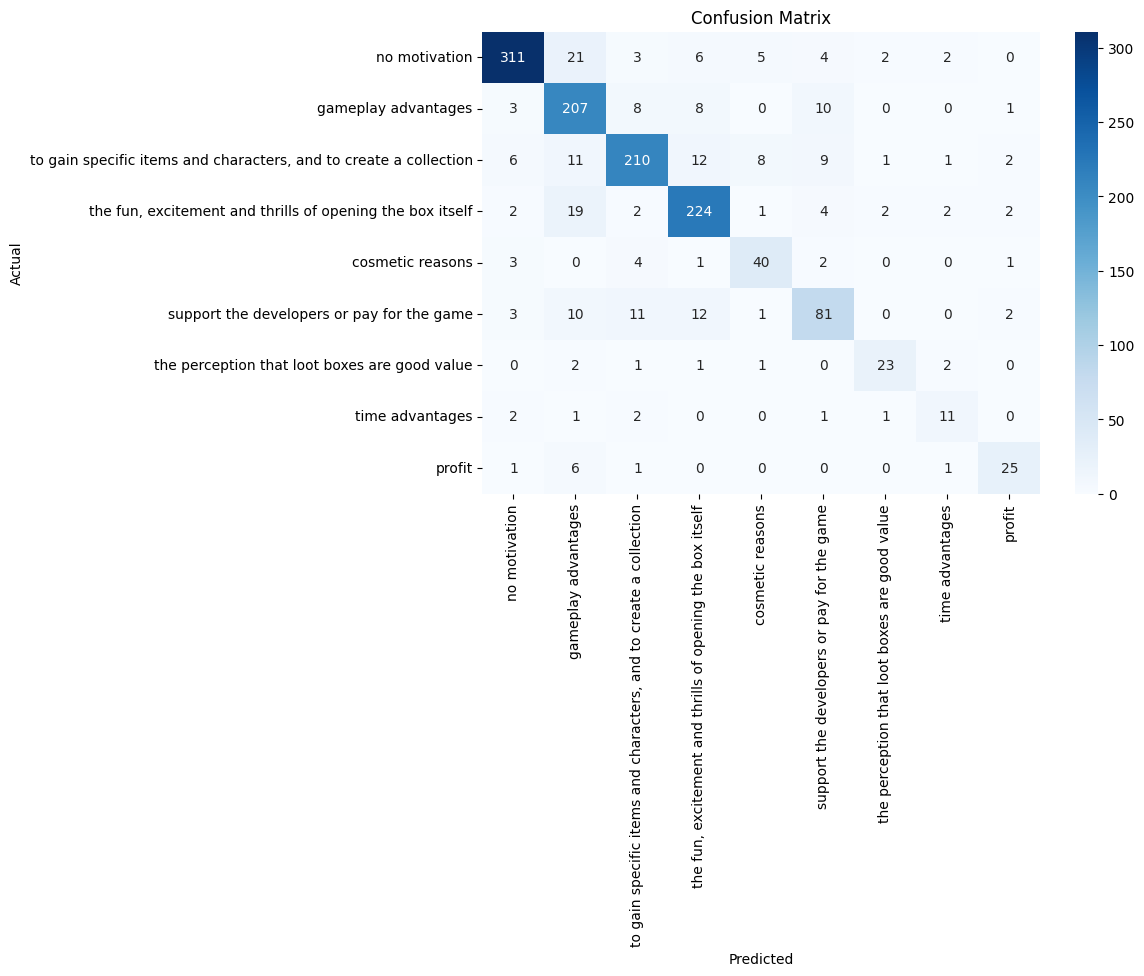

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetModel, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path_xl = '/content/combined_training_dataset.csv'
df_xl = pd.read_csv(file_path_xl)
df_xl = df_xl.dropna(subset=['Text'])

motivation_xl = {
    0: 'no motivation',
    2: 'gameplay advantages',
    5: 'to gain specific items and characters, and to create a collection',
    1: 'the fun, excitement and thrills of opening the box itself',
    3: 'cosmetic reasons',
    8: 'support the developers or pay for the game',
    7: 'the perception that loot boxes are good value',
    4: 'time advantages',
    6: 'profit'
}

tokenizer_xl = XLNetTokenizer.from_pretrained('xlnet-base-cased')

MAX_SEQ_LEN_XL = 512
BATCH_SIZE_XL = 12
PAD_INDEX_XL = tokenizer_xl.convert_tokens_to_ids(tokenizer_xl.pad_token)
UNK_INDEX_XL = tokenizer_xl.convert_tokens_to_ids(tokenizer_xl.unk_token)

def tokenize_and_cut_xl(sentence):
    tokens = tokenizer_xl.encode(sentence, max_length=MAX_SEQ_LEN_XL, truncation=True)
    return tokens

class TextDatasetXL(Dataset):
    def __init__(self, df):
        self.texts = df['Text'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = tokenize_and_cut_xl(text)
        tokens = torch.tensor(tokens)
        return tokens, int(label)

train_dataset_xl = TextDatasetXL(df_xl)

def collate_fn_xl(batch):
    input_ids = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    input_ids_padded = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=PAD_INDEX_XL)
    labels = torch.tensor(labels)
    return input_ids_padded.to(device), labels.to(device)

train_loader_xl = DataLoader(train_dataset_xl, batch_size=BATCH_SIZE_XL, shuffle=True, collate_fn=collate_fn_xl)

class XLNetClassifier(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(XLNetClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        for param in self.xlnet.parameters():
            param.requires_grad = False
        for param in self.xlnet.layer[-8:].parameters():
            param.requires_grad = True

        self.d1_xl = nn.Dropout(dropout_rate)
        self.l1_xl = nn.Linear(768, 64)
        self.bn1_xl = nn.LayerNorm(64)
        self.d2_xl = nn.Dropout(dropout_rate)
        self.l2_xl = nn.Linear(64, len(motivation_xl))

    def forward(self, input_ids, attention_mask=None):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, -1, :]
        x = self.d1_xl(x)
        x = self.l1_xl(x)
        x = self.bn1_xl(x)
        x = torch.nn.Tanh()(x)
        x = self.d2_xl(x)
        x = self.l2_xl(x)
        return x

model_xl = XLNetClassifier().to(device)

optimizer_xl = AdamW(model_xl.parameters(), lr=2e-5)
criterion_xl = nn.CrossEntropyLoss().to(device)

def train_model_xl(model_xl, loader_xl, optimizer_xl, criterion_xl):
    model_xl.train()
    epoch_loss_xl = 0
    epoch_acc_xl = 0
    for input_ids, labels in loader_xl:
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        attention_mask = (input_ids != PAD_INDEX_XL).float()

        optimizer_xl.zero_grad()
        predictions = model_xl(input_ids, attention_mask)
        loss = criterion_xl(predictions, labels)
        acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer_xl.step()

        epoch_loss_xl += loss.item()
        epoch_acc_xl += acc
    return epoch_loss_xl / len(loader_xl), epoch_acc_xl / len(loader_xl)

def evaluate_model_xl(model_xl, loader_xl, criterion_xl):
    model_xl.eval()
    epoch_loss_xl = 0
    epoch_acc_xl = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for input_ids, labels in loader_xl:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = (input_ids != PAD_INDEX_XL).float()

            predictions = model_xl(input_ids, attention_mask)
            loss = criterion_xl(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

            epoch_loss_xl += loss.item()
            epoch_acc_xl += acc

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return epoch_loss_xl / len(loader_xl), epoch_acc_xl / len(loader_xl), f1, precision, recall, conf_matrix

NUM_EPOCHS_XL = 30
for epoch in range(NUM_EPOCHS_XL):
    train_loss_xl, train_acc_xl = train_model_xl(model_xl, train_loader_xl, optimizer_xl, criterion_xl)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_xl:.3f}, Train Acc: {train_acc_xl:.3f}')

file_path_test = '/content/first_dataset_testing.csv'
df_test = pd.read_csv(file_path_test)
df_test = df_test.dropna(subset=['Text'])
df_test['text'] = df_test['Text']

test_dataset_xl = TextDatasetXL(df_test)
test_loader_xl = DataLoader(test_dataset_xl, batch_size=12, shuffle=False, collate_fn=collate_fn_xl)

def evaluate_model_xl_test(model_xl, loader_xl):
    model_xl.eval()
    epoch_loss_xl = 0
    epoch_acc_xl = 0
    all_labels = []
    all_predictions = []
    criterion_xl = nn.CrossEntropyLoss().to(device)

    with torch.no_grad():
        for input_ids, labels in loader_xl:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = (input_ids != tokenizer_xl.pad_token_id).float()

            predictions = model_xl(input_ids, attention_mask)
            loss = criterion_xl(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).sum().item() / len(labels)

            epoch_loss_xl += loss.item()
            epoch_acc_xl += acc

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return epoch_loss_xl / len(loader_xl), epoch_acc_xl / len(loader_xl), f1, precision, recall, conf_matrix

test_loss_xl, test_acc_xl, test_f1_xl, test_precision_xl, test_recall_xl, test_conf_matrix_xl = evaluate_model_xl_test(model_xl, test_loader_xl)
print(f'Test Loss: {test_loss_xl:.3f}, Test Accuracy: {test_acc_xl:.3f}, Test F1: {test_f1_xl:.3f}')
print(f'Test Precision: {test_precision_xl:.3f}, Test Recall: {test_recall_xl:.3f}')

print('Confusion Matrix:')
print(test_conf_matrix_xl)

plt.figure(figsize=(9, 6))
sns.heatmap(test_conf_matrix_xl, annot=True, fmt="d", cmap="Blues", xticklabels=motivation_xl.values(), yticklabels=motivation_xl.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Ensemble:


<ipython-input-7-a73545d873fb>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  all_logits_tensor = torch.tensor(all_logits).squeeze().to(device)  # Ensure it has the right shape


Ensemble Model Accuracy: 0.869
Ensemble Model Cohen's Kappa: 0.840
Ensemble Model F1 Score: 0.869
Ensemble Model Test Loss: 0.462
Confusion Matrix:
[[328  13   3   3   2   1   1   2   1]
 [  7 202  10   6   0  10   0   0   2]
 [  1   5 231   7   3   8   0   2   3]
 [  2  11   2 236   0   3   1   2   1]
 [  2   0   7   0  41   1   0   0   0]
 [  4   8  12   7   1  82   0   3   3]
 [  1   3   1   1   1   0  20   3   0]
 [  2   0   0   0   0   0   0  16   0]
 [  1   4   1   0   0   0   0   1  27]]


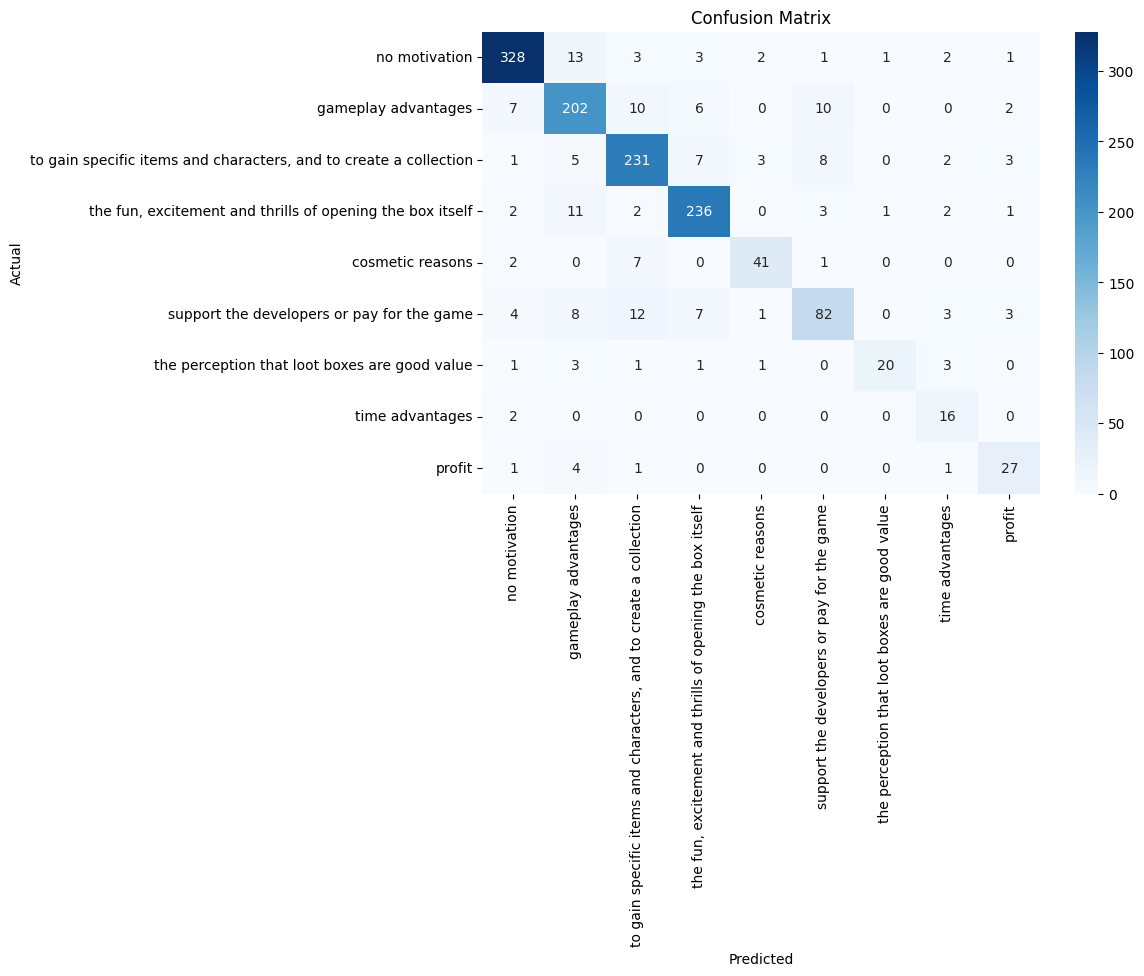

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get logits from a model (before softmax)
def get_logits(model, input_ids, attention_mask):
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs

# Ensemble prediction function
def ensemble_predict(input_ids_el, attention_mask_el, input_ids_rob, attention_mask_rob, input_ids_xl, attention_mask_xl):
    logits_el = get_logits(model_el, input_ids_el, attention_mask_el)
    logits_rob = get_logits(model_rob, input_ids_rob, attention_mask_rob)
    logits_xl = get_logits(model_xl, input_ids_xl, attention_mask_xl)

    avg_logits = (logits_el + logits_rob + logits_xl) / 3.0
    final_pred = torch.argmax(avg_logits, dim=1)
    return final_pred, avg_logits

# Preprocess and predict using the ensemble model
def ensemble_predict_texts(texts):
    all_preds = []
    all_logits = []
    for text in texts:
        inputs_el = tokenizer_el(text, return_tensors="pt", truncation=True, padding=True).to(device)
        inputs_rob = tokenizer_rob(text, return_tensors="pt", truncation=True, padding=True).to(device)
        inputs_xl = tokenizer_xl(text, return_tensors="pt", truncation=True, padding=True).to(device)

        input_ids_el, attention_mask_el = inputs_el['input_ids'], inputs_el['attention_mask']
        input_ids_rob, attention_mask_rob = inputs_rob['input_ids'], inputs_rob['attention_mask']
        input_ids_xl, attention_mask_xl = inputs_xl['input_ids'], inputs_xl['attention_mask']

        final_preds, logits = ensemble_predict(input_ids_el, attention_mask_el, input_ids_rob, attention_mask_rob, input_ids_xl, attention_mask_xl)
        all_preds.append(final_preds.item())
        all_logits.append(logits.cpu().numpy())  # Store the logits for loss calculation

    return all_preds, all_logits

# Load the test dataset from code
file_path_test = '/content/first_dataset_testing.csv'
df_test = pd.read_csv(file_path_test)
df_test = df_test.dropna(subset=['Text'])

# The text is under 'Text' and labels are under 'label'
df_test['text'] = df_test['Text']

texts = df_test['text'].tolist()
true_labels = df_test['label'].tolist()

# Predict using the ensemble model
predicted_labels, all_logits = ensemble_predict_texts(texts)

# Convert true labels to a tensor
true_labels_tensor = torch.tensor(true_labels).to(device)

# Convert all_logits to a tensor and calculate loss
all_logits_tensor = torch.tensor(all_logits).squeeze().to(device)  # Ensure it has the right shape
criterion = nn.CrossEntropyLoss()
test_loss = criterion(all_logits_tensor, true_labels_tensor).item()

# Evaluate the ensemble model
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Ensemble Model Accuracy: {accuracy:.3f}')
print(f'Ensemble Model Cohen\'s Kappa: {kappa:.3f}')
print(f'Ensemble Model F1 Score: {f1:.3f}')
print(f'Ensemble Model Test Loss: {test_loss:.3f}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=motivation_rob.values(), yticklabels=motivation_rob.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Ensemble Model Accuracy: 0.869
Ensemble Model Cohen's Kappa: 0.840
Ensemble Model F1 Score: 0.869
Ensemble Model Precision: 0.871
Ensemble Model Recall: 0.869
Ensemble Model Test Loss: 0.462
Confusion Matrix:
[[328  13   3   3   2   1   1   2   1]
 [  7 202  10   6   0  10   0   0   2]
 [  1   5 231   7   3   8   0   2   3]
 [  2  11   2 236   0   3   1   2   1]
 [  2   0   7   0  41   1   0   0   0]
 [  4   8  12   7   1  82   0   3   3]
 [  1   3   1   1   1   0  20   3   0]
 [  2   0   0   0   0   0   0  16   0]
 [  1   4   1   0   0   0   0   1  27]]


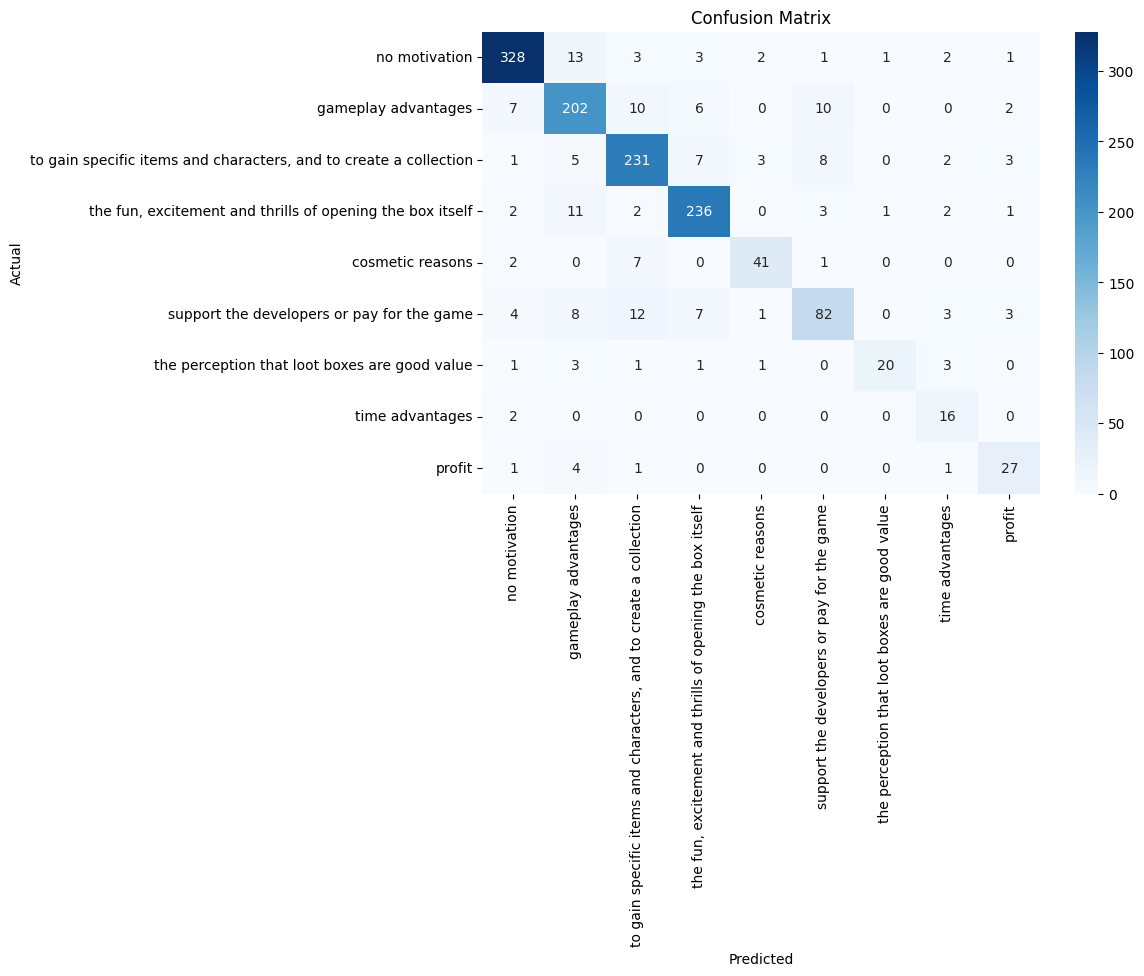

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, precision_score, recall_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get logits from a model (before softmax)
def get_logits(model, input_ids, attention_mask):
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs

# Ensemble prediction function
def ensemble_predict(input_ids_el, attention_mask_el, input_ids_rob, attention_mask_rob, input_ids_xl, attention_mask_xl):
    logits_el = get_logits(model_el, input_ids_el, attention_mask_el)
    logits_rob = get_logits(model_rob, input_ids_rob, attention_mask_rob)
    logits_xl = get_logits(model_xl, input_ids_xl, attention_mask_xl)

    avg_logits = (logits_el + logits_rob + logits_xl) / 3.0
    final_pred = torch.argmax(avg_logits, dim=1)
    return final_pred, avg_logits

# Preprocess and predict using the ensemble model
def ensemble_predict_texts(texts):
    all_preds = []
    all_logits = []
    for text in texts:
        inputs_el = tokenizer_el(text, return_tensors="pt", truncation=True, padding=True).to(device)
        inputs_rob = tokenizer_rob(text, return_tensors="pt", truncation=True, padding=True).to(device)
        inputs_xl = tokenizer_xl(text, return_tensors="pt", truncation=True, padding=True).to(device)

        input_ids_el, attention_mask_el = inputs_el['input_ids'], inputs_el['attention_mask']
        input_ids_rob, attention_mask_rob = inputs_rob['input_ids'], inputs_rob['attention_mask']
        input_ids_xl, attention_mask_xl = inputs_xl['input_ids'], inputs_xl['attention_mask']

        final_preds, logits = ensemble_predict(input_ids_el, attention_mask_el, input_ids_rob, attention_mask_rob, input_ids_xl, attention_mask_xl)
        all_preds.append(final_preds.item())
        all_logits.append(logits.cpu().numpy())  # Store the logits for loss calculation

    return all_preds, all_logits

# Load the test dataset from code
file_path_test = '/content/first_dataset_testing.csv'
df_test = pd.read_csv(file_path_test)
df_test = df_test.dropna(subset=['Text'])

# The text is under 'Text' and labels are under 'label'
df_test['text'] = df_test['Text']

texts = df_test['text'].tolist()
true_labels = df_test['label'].tolist()

# Predict using the ensemble model
predicted_labels, all_logits = ensemble_predict_texts(texts)

# Convert true labels to a tensor
true_labels_tensor = torch.tensor(true_labels).to(device)

# Convert all_logits to a tensor and calculate loss
all_logits_tensor = torch.tensor(all_logits).squeeze().to(device)  # Ensure it has the right shape
criterion = nn.CrossEntropyLoss()
test_loss = criterion(all_logits_tensor, true_labels_tensor).item()

# Evaluate the ensemble model
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Ensemble Model Accuracy: {accuracy:.3f}')
print(f'Ensemble Model Cohen\'s Kappa: {kappa:.3f}')
print(f'Ensemble Model F1 Score: {f1:.3f}')
print(f'Ensemble Model Precision: {precision:.3f}')
print(f'Ensemble Model Recall: {recall:.3f}')
print(f'Ensemble Model Test Loss: {test_loss:.3f}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=motivation_rob.values(), yticklabels=motivation_rob.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [4]:
import pandas as pd

df_testing = pd.read_csv('/content/first_dataset_testing.csv')
df_training = pd.read_csv('/content/combined_training_dataset.csv')

df_testing['label'].value_counts(), df_training['label'].value_counts()

(label
 0    356
 2    260
 3    258
 1    237
 5    120
 4     51
 8     34
 6     30
 7     18
 Name: count, dtype: int64,
 label
 2    675
 1    539
 3    534
 0    454
 5    415
 8    251
 7    218
 4    170
 6     61
 Name: count, dtype: int64)